# **Libraries :**

In [ ]:
# Core & System
import os
import cv2
import numpy as np
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Google Colab & File Handling
from google.colab import drive, files
import zipfile
import glob

# Data Handling & Analysis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

# Image & Video Handling
import imageio
from imutils import paths
from IPython.display import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries (Keras & PyTorch)
import keras
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
from torch.optim.lr_scheduler import ReduceLROnPlateau
!pip install torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

# Progress Bars
from tqdm import tqdm

# YOLO for Person Detection
!pip install ultralytics
from ultralytics import YOLO



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Data Import :**

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Shop DataSet.zip'
extract_to = '/content/ShopDataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/ShopDataset')


['Shop DataSet']

In [ ]:
#Set Paths to Folders

shoplifters = os.path.join(extract_to, 'Shop DataSet', 'shop lifters')
nonshoplifters = os.path.join(extract_to, 'Shop DataSet', 'non shop lifters')

# **EDA – Exploratory Data Analysis :**

In [ ]:
print("Shoplifters videos:", len(os.listdir(shoplifters)))
print("Non-shoplifters videos:", len(os.listdir(nonshoplifters)))


Shoplifters videos: 324
Non-shoplifters videos: 531


# **Preprocessing :**

In [ ]:
# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 25
MAX_SEQ_LENGTH = 16
NUM_FEATURES = 2048

In [ ]:
# Create dataframe from folders
def create_dataframe():
    video_paths = []
    labels = []

    for path in os.listdir(shoplifters):
        video_paths.append(os.path.join(shoplifters, path))
        labels.append("shoplifter")

    for path in os.listdir(nonshoplifters):
        video_paths.append(os.path.join(nonshoplifters, path))
        labels.append("non-shoplifter")

    return np.array(video_paths), np.array(labels)

video_paths, labels = create_dataframe()
print(f"Total videos: {len(video_paths)}")


Total videos: 855


In [ ]:
# Split train/test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42)


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim]

def sample_frames_uniformly(frames, num_frames):
    total_frames = len(frames)
    if total_frames >= num_frames:
        indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        return [frames[i] for i in indices]
    else:
        # If the video is short, we repeat the frames.
        repeat_factor = int(np.ceil(num_frames / total_frames))
        frames = frames * repeat_factor
        return frames[:num_frames]

def load_video(path, resize=(IMG_SIZE, IMG_SIZE), max_frames=MAX_SEQ_LENGTH):
    cap = cv2.VideoCapture(path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frames.append(frame)
    cap.release()

    # Select 16 Frame Distributors
    frames = sample_frames_uniformly(frames, max_frames)
    return np.array(frames)


In [ ]:
# Feature Extractor
def build_feature_extractor():
    base_model = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    x = preprocess_input(inputs)
    outputs = base_model(x)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()


In [ ]:
# Data Generator
class VideoFrameGenerator(keras.utils.Sequence):
    def __init__(self, paths, labels, batch_size):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(paths))
        self.label_map = {label: idx for idx, label in enumerate(np.unique(labels))}

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        batch_features = np.zeros((len(batch_paths), MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")
        batch_masks = np.zeros((len(batch_paths), MAX_SEQ_LENGTH), dtype="bool")
        batch_targets = np.zeros((len(batch_paths)), dtype="int32")

        for i, path in enumerate(batch_paths):
            frames = load_video(path)
            for j in range(MAX_SEQ_LENGTH):
                feat = feature_extractor.predict(frames[None, j, :], verbose=0)
                batch_features[i, j, :] = feat
            batch_masks[i, :] = 1
            batch_targets[i] = self.label_map[batch_labels[i]]

        return (batch_features, batch_masks), batch_targets

train_gen = VideoFrameGenerator(train_paths, train_labels, BATCH_SIZE)
test_gen = VideoFrameGenerator(test_paths, test_labels, BATCH_SIZE)

print(f"Train batches: {len(train_gen)}, Test batches: {len(test_gen)}")

Train batches: 86, Test batches: 22


# **CNN + GRU :**

In [ ]:
# Create label processor from current labels
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print("Class vocabulary:", label_processor.get_vocabulary())

Class vocabulary: [np.str_('non-shoplifter'), np.str_('shoplifter')]


In [ ]:
# Sequence Model

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return rnn_model

def run_experiment():
    filepath = "video_classifier_best.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()

    # Print model summary
    print("\n Sequence Model Summary ")
    seq_model.summary()

    return seq_model, checkpoint, filepath


In [ ]:
# Run Training
seq_model, checkpoint, filepath = run_experiment()

history = seq_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1
)

seq_model.load_weights(filepath)
_, accuracy = seq_model.evaluate(test_gen)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")



 Sequence Model Summary 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 16, 2048)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 16, 16)    │     99,168 │ input_layer_4[0]… │
│                     │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        624 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         72 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         18 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,882 (390.16 KB)

 Trainable params: 99,882 (390.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5119 - loss: 0.7178 
Epoch 1: val_loss improved from inf to 0.64373, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1563s 18s/step - accuracy: 0.5124 - loss: 0.7175 - val_accuracy: 0.6199 - val_loss: 0.6437
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5988 - loss: 0.6524 
Epoch 2: val_loss improved from 0.64373 to 0.58166, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1554s 18s/step - accuracy: 0.5989 - loss: 0.6523 - val_accuracy: 0.6199 - val_loss: 0.5817
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6307 - loss: 0.5887 
Epoch 3: val_loss improved from 0.58166 to 0.54509, saving model to video_classifier_best.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1591s 19s/step - accuracy: 0.6312 - loss: 0.5884 - val_accuracy: 0.8830 - val_loss: 0.5451
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7843 - loss: 0.5121 
Epoch 4

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

In [ ]:
train_acc = history.history["accuracy"][-1]       # last epoch
val_acc = history.history["val_accuracy"][-1]

# Model evaluation on test_gen
test_loss, test_acc = seq_model.evaluate(test_gen)

print(f"Training Accuracy   : {round(train_acc*100, 2)}%")
print(f"Validation Accuracy : {round(val_acc*100, 2)}%")
print(f"Testing Accuracy    : {round(test_acc*100, 2)}%")


In [ ]:
# Save the entire model(architecture + weights + optimizer)
MODEL_PATH = "video_sequence_model.h5"
seq_model.save(MODEL_PATH)
print(f"Model saved successfully at {MODEL_PATH}")

files.download(MODEL_PATH)


#**Pretrained (MAE) : preprocessing**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 25
MAX_SEQ_LENGTH = 16
NUM_FEATURES = 2048
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#Create list of video paths and labels
video_paths, labels = [], []
for path in os.listdir(shoplifters):
    video_paths.append(os.path.join(shoplifters, path))
    labels.append(1)  # shoplifter = 1
for path in os.listdir(nonshoplifters):
    video_paths.append(os.path.join(nonshoplifters, path))
    labels.append(0)  # non-shoplifter = 0

In [ ]:
# Split train / val / test
train_paths, test_paths, y_train, y_test = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
val_paths, test_paths, y_val, y_test = train_test_split(
    test_paths, y_test, test_size=0.5, stratify=y_test, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 684, Val: 85, Test: 86


In [ ]:
#Dataset class
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=MAX_SEQ_LENGTH, size=(IMG_SIZE, IMG_SIZE)):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.size = size

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, self.size)
            frames.append(frame)
        cap.release()

        total = len(frames)
        if total >= self.num_frames:
            indices = np.linspace(0, total - 1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        else:
            frames += [frames[-1]] * (self.num_frames - total)

        frames = np.array(frames, dtype=np.float32) / 255.0
        frames = torch.tensor(frames).permute(0, 3, 1, 2)  # (T, C, H, W)
        return frames, label


In [ ]:
# Model class
class EfficientNetB0_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=1):
        super().__init__()
        backbone = efficientnet_b0(pretrained=True)
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x)
        feats = feats.view(b, t, -1)
        _, (h_n, _) = self.lstm(feats)
        h_n = h_n.squeeze(0)
        out = self.dropout(h_n)
        out = self.fc(out)
        return torch.sigmoid(out)


In [ ]:
# Dataloaders
train_dataset = VideoDataset(train_paths, y_train)
val_dataset = VideoDataset(val_paths, y_val)
test_dataset = VideoDataset(test_paths, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


#**Pretrained (MAE) : Building & Evaluation**

In [ ]:
# Training function
def train_model(epochs=EPOCHS):
    model = EfficientNetB0_LSTM().to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    f1_metric = BinaryF1Score().to(DEVICE)
    acc_metric = BinaryAccuracy().to(DEVICE)

    best_val_loss = float('inf')
    patience = 5
    no_improve_epochs = 0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'train_f1':[], 'val_f1':[]}

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, total_f1, total_acc = 0, 0, 0
        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(videos).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = (outputs>0.5).int()
            total_loss += loss.item()
            total_f1 += f1_metric(preds, labels.int()).item()
            total_acc += acc_metric(preds, labels.int()).item()

        avg_loss = total_loss/len(train_loader)
        avg_f1 = total_f1/len(train_loader)
        avg_acc = total_acc/len(train_loader)
        history['train_loss'].append(avg_loss)
        history['train_f1'].append(avg_f1)
        history['train_acc'].append(avg_acc)

        # Validation
        model.eval()
        val_loss, val_f1, val_acc = 0,0,0
        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.to(DEVICE), labels.to(DEVICE)
                outputs = model(videos).squeeze(1)
                loss = criterion(outputs, labels)
                preds = (outputs>0.5).int()
                val_loss += loss.item()
                val_f1 += f1_metric(preds, labels.int()).item()
                val_acc += acc_metric(preds, labels.int()).item()

        avg_val_loss = val_loss/len(val_loader)
        avg_val_f1 = val_f1/len(val_loader)
        avg_val_acc = val_acc/len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(avg_val_f1)
        history['val_acc'].append(avg_val_acc)

        print(f"Epoch {epoch+1} -> Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f} | "
              f"Train F1: {avg_f1:.4f}, Val F1: {avg_val_f1:.4f} | Train Acc: {avg_acc:.4f}, Val Acc: {avg_val_acc:.4f}")

        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved — saved")
        else:
            no_improve_epochs +=1
            if no_improve_epochs >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(torch.load("best_model.pth"))
    return model, history


In [ ]:
# Evaluation function
def evaluate(model, loader, name="Eval"):
    criterion = nn.BCELoss()
    acc_metric = BinaryAccuracy().to(DEVICE)
    f1_metric = BinaryF1Score().to(DEVICE)
    model.eval()
    total_loss, total_acc, total_f1 = 0,0,0
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(videos).squeeze(1)
            loss = criterion(outputs, labels)
            preds = (outputs>0.5).int()
            total_loss += loss.item()
            total_acc += acc_metric(preds, labels.int()).item()
            total_f1 += f1_metric(preds, labels.int()).item()
    n = len(loader)
    print(f"{name} -> Loss: {total_loss/n:.4f}, Acc: {total_acc/n:.4f}, F1: {total_f1/n:.4f}")


In [ ]:
# Run Training & Evaluation
model, history = train_model(EPOCHS)

print('Training Results:')
evaluate(model, train_loader, "Train")

print("\nValidation Results:")
evaluate(model, val_loader, "Validation")

print("\nTest Results:")
evaluate(model, test_loader, "Test")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 164MB/s]
Epoch 1: 100%|██████████| 86/86 [06:02<00:00,  4.21s/it]


Epoch 1 -> Train Loss: 0.6198, Val Loss: 0.4639 | Train F1: 0.2013, Val F1: 0.7416 | Train Acc: 0.6512, Val Acc: 0.8523
Model improved — saved


Epoch 2: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 2 -> Train Loss: 0.3555, Val Loss: 0.1383 | Train F1: 0.8187, Val F1: 0.9616 | Train Acc: 0.8794, Val Acc: 0.9659
Model improved — saved


Epoch 3: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 3 -> Train Loss: 0.2649, Val Loss: 0.1007 | Train F1: 0.8397, Val F1: 0.9715 | Train Acc: 0.8910, Val Acc: 0.9659
Model improved — saved


Epoch 4: 100%|██████████| 86/86 [05:51<00:00,  4.09s/it]


Epoch 4 -> Train Loss: 0.1439, Val Loss: 0.0469 | Train F1: 0.9134, Val F1: 1.0000 | Train Acc: 0.9477, Val Acc: 1.0000
Model improved — saved


Epoch 5: 100%|██████████| 86/86 [05:50<00:00,  4.08s/it]


Epoch 5 -> Train Loss: 0.1659, Val Loss: 0.0723 | Train F1: 0.9066, Val F1: 0.9769 | Train Acc: 0.9419, Val Acc: 0.9773


Epoch 6: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 6 -> Train Loss: 0.1264, Val Loss: 0.0342 | Train F1: 0.9181, Val F1: 1.0000 | Train Acc: 0.9680, Val Acc: 1.0000
Model improved — saved


Epoch 7: 100%|██████████| 86/86 [05:58<00:00,  4.17s/it]


Epoch 7 -> Train Loss: 0.1231, Val Loss: 0.0456 | Train F1: 0.9273, Val F1: 0.9870 | Train Acc: 0.9680, Val Acc: 0.9886


Epoch 8: 100%|██████████| 86/86 [06:05<00:00,  4.25s/it]


Epoch 8 -> Train Loss: 0.0759, Val Loss: 0.0246 | Train F1: 0.9509, Val F1: 0.9870 | Train Acc: 0.9782, Val Acc: 0.9886
Model improved — saved


Epoch 9: 100%|██████████| 86/86 [05:56<00:00,  4.14s/it]


Epoch 9 -> Train Loss: 0.0959, Val Loss: 0.0211 | Train F1: 0.9476, Val F1: 1.0000 | Train Acc: 0.9753, Val Acc: 1.0000
Model improved — saved


Epoch 10: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 10 -> Train Loss: 0.0633, Val Loss: 0.0272 | Train F1: 0.9636, Val F1: 0.9870 | Train Acc: 0.9840, Val Acc: 0.9886


Epoch 11: 100%|██████████| 86/86 [05:57<00:00,  4.16s/it]


Epoch 11 -> Train Loss: 0.0752, Val Loss: 0.0168 | Train F1: 0.9332, Val F1: 1.0000 | Train Acc: 0.9782, Val Acc: 1.0000
Model improved — saved


Epoch 12: 100%|██████████| 86/86 [05:56<00:00,  4.15s/it]


Epoch 12 -> Train Loss: 0.0524, Val Loss: 0.0149 | Train F1: 0.9654, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000
Model improved — saved


Epoch 13: 100%|██████████| 86/86 [05:54<00:00,  4.12s/it]


Epoch 13 -> Train Loss: 0.0561, Val Loss: 0.0106 | Train F1: 0.9635, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000
Model improved — saved


Epoch 14: 100%|██████████| 86/86 [06:01<00:00,  4.20s/it]


Epoch 14 -> Train Loss: 0.0393, Val Loss: 0.0107 | Train F1: 0.9820, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000


Epoch 15: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 15 -> Train Loss: 0.0306, Val Loss: 0.0060 | Train F1: 0.9627, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000
Model improved — saved


Epoch 16: 100%|██████████| 86/86 [05:56<00:00,  4.15s/it]


Epoch 16 -> Train Loss: 0.0246, Val Loss: 0.0056 | Train F1: 0.9694, Val F1: 1.0000 | Train Acc: 0.9927, Val Acc: 1.0000
Model improved — saved


Epoch 17: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 17 -> Train Loss: 0.0987, Val Loss: 0.0082 | Train F1: 0.8780, Val F1: 1.0000 | Train Acc: 0.9608, Val Acc: 1.0000


Epoch 18: 100%|██████████| 86/86 [05:49<00:00,  4.07s/it]


Epoch 18 -> Train Loss: 0.0301, Val Loss: 0.0061 | Train F1: 0.9565, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000


Epoch 19: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 19 -> Train Loss: 0.0203, Val Loss: 0.0044 | Train F1: 0.9599, Val F1: 1.0000 | Train Acc: 0.9956, Val Acc: 1.0000
Model improved — saved


Epoch 20: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 20 -> Train Loss: 0.0697, Val Loss: 0.0060 | Train F1: 0.9678, Val F1: 1.0000 | Train Acc: 0.9811, Val Acc: 1.0000


Epoch 21: 100%|██████████| 86/86 [05:52<00:00,  4.10s/it]


Epoch 21 -> Train Loss: 0.0206, Val Loss: 0.0048 | Train F1: 0.9511, Val F1: 1.0000 | Train Acc: 0.9956, Val Acc: 1.0000


Epoch 22: 100%|██████████| 86/86 [05:51<00:00,  4.09s/it]


Epoch 22 -> Train Loss: 0.0393, Val Loss: 0.0070 | Train F1: 0.9639, Val F1: 1.0000 | Train Acc: 0.9898, Val Acc: 1.0000


Epoch 23: 100%|██████████| 86/86 [05:55<00:00,  4.13s/it]


Epoch 23 -> Train Loss: 0.0284, Val Loss: 0.0036 | Train F1: 0.9695, Val F1: 1.0000 | Train Acc: 0.9898, Val Acc: 1.0000
Model improved — saved


Epoch 24: 100%|██████████| 86/86 [05:53<00:00,  4.11s/it]


Epoch 24 -> Train Loss: 0.0243, Val Loss: 0.0036 | Train F1: 0.9740, Val F1: 1.0000 | Train Acc: 0.9942, Val Acc: 1.0000
Model improved — saved


Epoch 25: 100%|██████████| 86/86 [05:50<00:00,  4.08s/it]


Epoch 25 -> Train Loss: 0.0237, Val Loss: 0.0033 | Train F1: 0.9547, Val F1: 1.0000 | Train Acc: 0.9913, Val Acc: 1.0000
Model improved — saved
Training Results:
Train -> Loss: 0.0032, Acc: 1.0000, F1: 0.9651

Validation Results:
Validation -> Loss: 0.0033, Acc: 1.0000, F1: 1.0000

Test Results:
Test -> Loss: 0.0033, Acc: 1.0000, F1: 1.0000


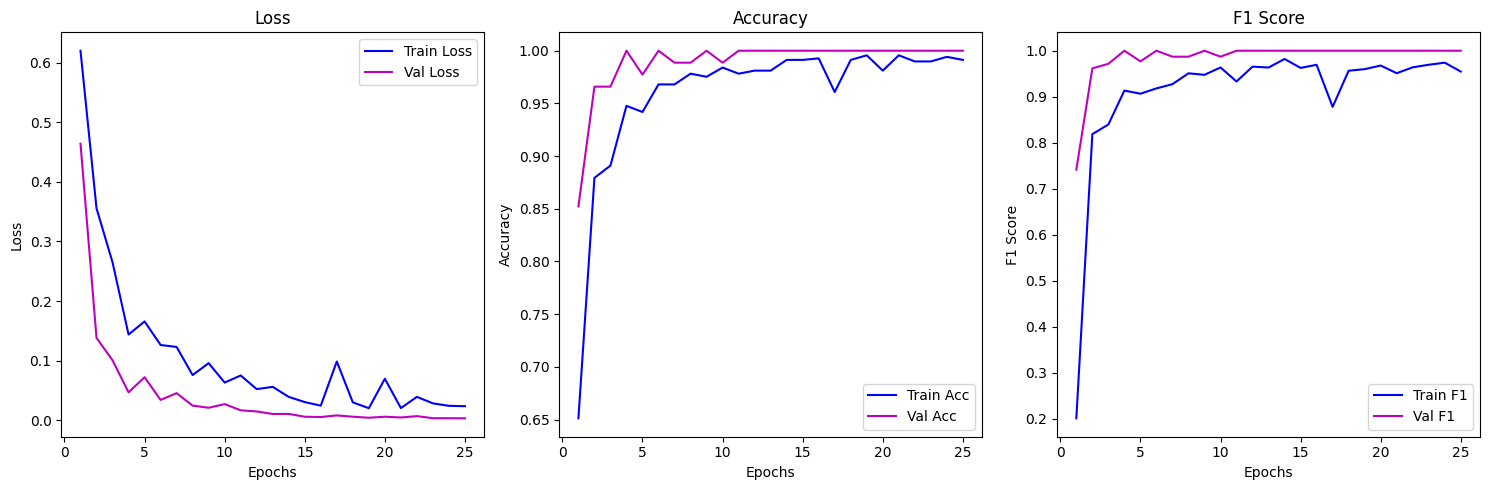

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='b')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color='b')
    plt.plot(epochs, history['val_acc'], label='Val Acc', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # F1 Score plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_f1'], label='Train F1', color='b')
    plt.plot(epochs, history['val_f1'], label='Val F1', color='m')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("F1 Score")

    plt.tight_layout()
    plt.show()

plot_training_history(history)


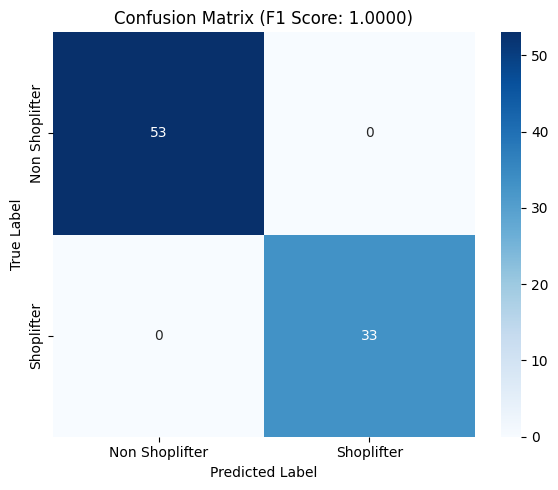

In [ ]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in dataloader:
            videos, labels = videos.float().to(device), labels.to(device)
            outputs = model(videos)
            preds = (outputs.squeeze(1) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, pos_label=1)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (F1 Score: {f1:.4f})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(model, test_loader, ["Non Shoplifter", "Shoplifter"], DEVICE)


In [ ]:
IMG_SIZE = 224  # Make sure it is the same size used for training

def predict_video(model, video_path, device, threshold=0.5):
    model.eval()
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, (IMG_SIZE, IMG_SIZE))
        frame_tensor = torch.tensor(frame_resized).permute(2, 0, 1).float() / 255.0
        frames.append(frame_tensor)
    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames found in video.")

    video_tensor = torch.stack(frames).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(video_tensor).squeeze(1)
        prob = torch.sigmoid(outputs).item()

    predicted_class = "Shoplifter" if prob > threshold else "Non Shoplifter"
    return predicted_class, prob

# Try predicting on a new video.
video_path = '/content/ShopDataset/Shop DataSet/shop lifters/shop_lifter_36.mp4'
label, prob = predict_video(model, video_path, DEVICE)
print(f'Prediction: {label} (Confidence: {prob:.4f})')


Prediction: Shoplifter (Confidence: 0.7298)


Video saved as 'output.mp4'


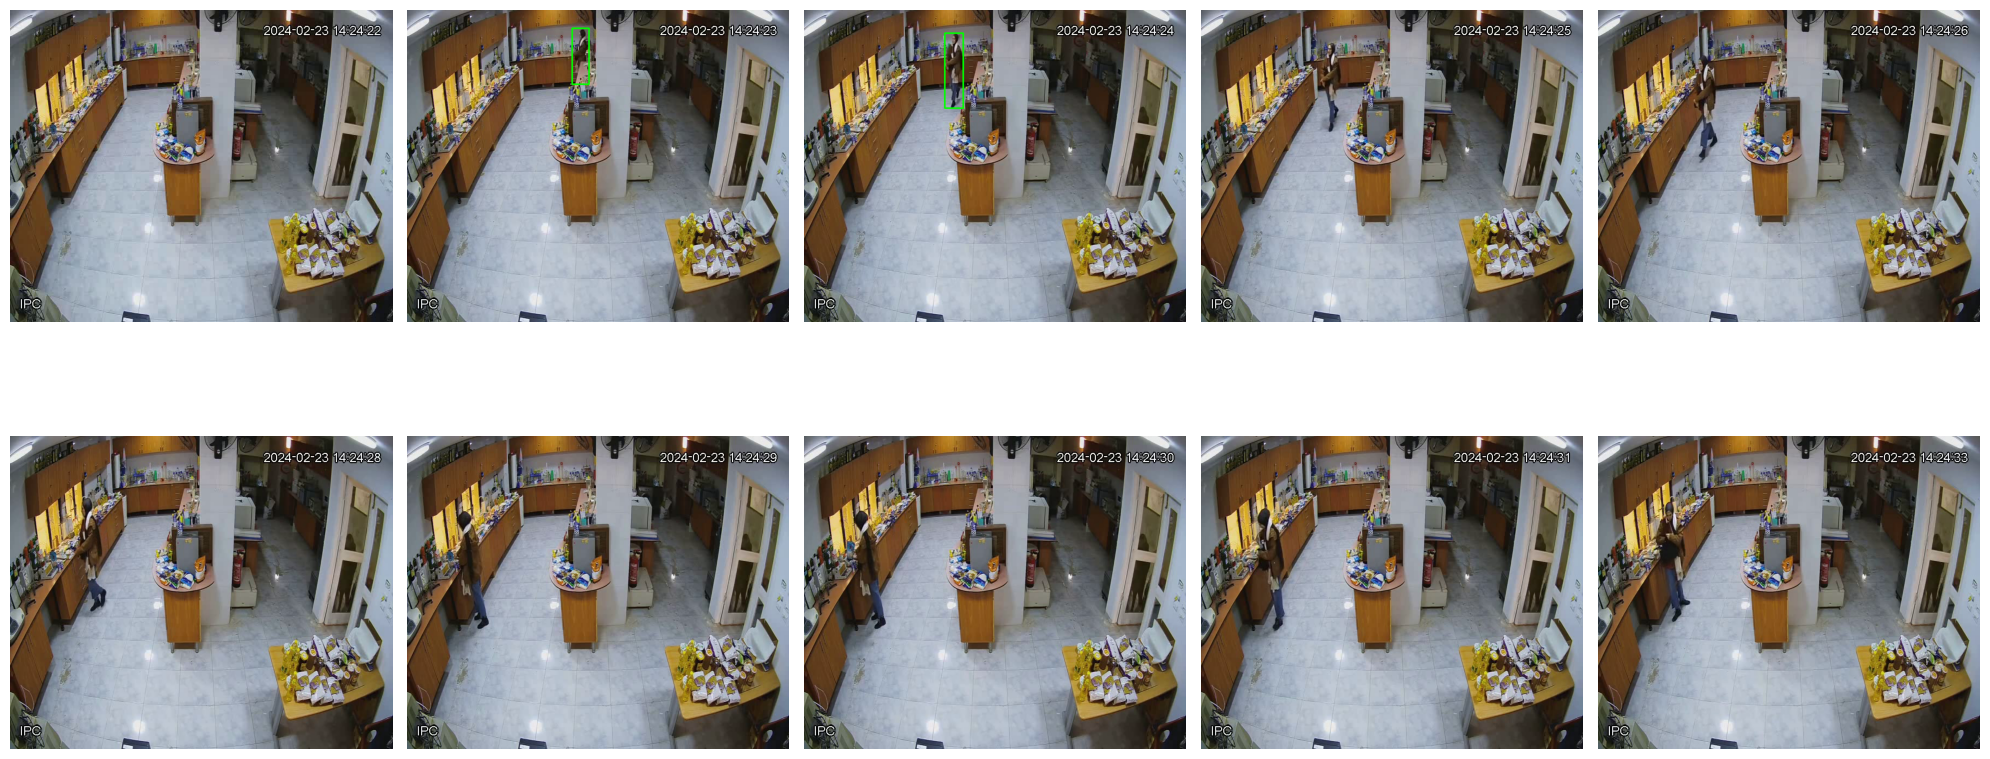

In [ ]:
def visualize_frames(vid_path):
    yolo_model = YOLO('yolov8n.pt')  # Pretrained YOLOv8 Model

    cap = cv2.VideoCapture(vid_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

    frames_to_show = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = yolo_model.predict(frame, classes=[0], verbose=False)
        for box in results[0].boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        out.write(frame)
        if frame_count % 30 == 0:
            frames_to_show.append(frame.copy())
        frame_count += 1

    cap.release()
    out.release()
    print("Video saved as 'output.mp4'")

    while len(frames_to_show) < 10:
        frames_to_show.append(np.zeros_like(frames_to_show[0]))

    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(frames_to_show[i], cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_frames(video_path)


In [ ]:
# Save Model
MODEL_PATH = "shoplifter_model.pth"

# Save model wieghts
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved successfully at: {MODEL_PATH}")

#  Download Model
files.download(MODEL_PATH)


 Model saved successfully at: shoplifter_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deployment :الحلو **

In [19]:
!pip install torch torchvision opencv-python-headless
!pip install efficientnet-pytorch
!pip install ipywidgets


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=fc6c1bde69a1ca5c7226ea5c79f28c2832c4f76d5949f403aaa34e9dbe4549eb
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.4 MB/s eta 0:00:00


In [20]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import efficientnet_b0
import time
import os
from pathlib import Path
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, interact, Layout
import io
from PIL import Image
import base64

In [ ]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


In [21]:
# Model Definition
class EfficientNetB0_LSTM(nn.Module):
    """
    EfficientNet-B0 + LSTM model for video classification
    """
    def __init__(self, hidden_size=128, num_classes=1):
        super().__init__()
        # Use EfficientNet-B0 as backbone
        backbone = efficientnet_b0(pretrained=True)
        # Remove the final classification layer
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        # Freeze backbone parameters for faster training/inference
        for param in self.backbone.parameters():
            param.requires_grad = False

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, channels, height, width)
        b, t, c, h, w = x.shape

        # Reshape to process all frames at once
        x = x.view(b * t, c, h, w)

        # Extract features using EfficientNet
        feats = self.backbone(x)  # Shape: (b*t, 1280)

        # Reshape back to sequence format
        feats = feats.view(b, t, -1)  # Shape: (b, t, 1280)

        # Process sequence with LSTM
        _, (h_n, _) = self.lstm(feats)  # h_n shape: (1, b, hidden_size)
        h_n = h_n.squeeze(0)  # Shape: (b, hidden_size)

        # Final classification
        out = self.dropout(h_n)
        out = self.fc(out)

        return torch.sigmoid(out)

print("Model class defined successfully!")

Model class defined successfully!


In [22]:
class VideoProcessor:
    def __init__(self, img_size=224, max_seq_length=16):
        self.img_size = img_size
        self.max_seq_length = max_seq_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Image preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def extract_frames(self, video_path):
        """Extract frames from video file"""
        cap = cv2.VideoCapture(str(video_path))
        frames = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = total_frames / fps if fps > 0 else 0

        print(f"Video info: {total_frames} frames, {fps:.2f} FPS, {duration:.2f}s duration")

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            frame_count += 1

            # Show progress for long videos
            if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames")

        cap.release()

        if len(frames) == 0:
            raise ValueError("No frames found in video")

        print(f"Extracted {len(frames)} frames")
        return frames

    def preprocess_frames(self, frames):
        """Preprocess frames for model input"""
        # Sample frames to match sequence length
        total_frames = len(frames)

        if total_frames >= self.max_seq_length:
            # Sample frames uniformly across the video
            indices = np.linspace(0, total_frames - 1, self.max_seq_length, dtype=int)
            selected_frames = [frames[i] for i in indices]
        else:
            # Pad with last frame if video is too short
            selected_frames = frames + [frames[-1]] * (self.max_seq_length - total_frames)

        # Convert to tensors and apply preprocessing
        processed_frames = []
        for frame in selected_frames:
            pil_frame = Image.fromarray(frame)
            tensor_frame = self.transform(pil_frame)
            processed_frames.append(tensor_frame)

        # Stack frames and add batch dimension
        video_tensor = torch.stack(processed_frames).unsqueeze(0)  # Shape: (1, seq_len, 3, H, W)

        return video_tensor.to(self.device)

    def create_frame_montage(self, frames, max_frames=8):
        """Create a montage of frames for visualization"""
        selected_frames = frames[::len(frames)//min(max_frames, len(frames))][:max_frames]

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()

        for i, frame in enumerate(selected_frames):
            if i < len(axes):
                axes[i].imshow(frame)
                axes[i].set_title(f'Frame {i+1}')
                axes[i].axis('off')

        # Hide unused subplots
        for i in range(len(selected_frames), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

print("Video processing functions defined successfully!")


Video processing functions defined successfully!


In [23]:
# Video Processing Functions
class VideoProcessor:
    def __init__(self, img_size=224, max_seq_length=16):
        self.img_size = img_size
        self.max_seq_length = max_seq_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Image preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def extract_frames(self, video_path):
        """Extract frames from video file"""
        cap = cv2.VideoCapture(str(video_path))
        frames = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = total_frames / fps if fps > 0 else 0

        print(f"Video info: {total_frames} frames, {fps:.2f} FPS, {duration:.2f}s duration")

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            frame_count += 1

            # Show progress for long videos
            if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames")

        cap.release()

        if len(frames) == 0:
            raise ValueError("No frames found in video")

        print(f"Extracted {len(frames)} frames")
        return frames

    def preprocess_frames(self, frames):
        """Preprocess frames for model input"""
        # Sample frames to match sequence length
        total_frames = len(frames)

        if total_frames >= self.max_seq_length:
            # Sample frames uniformly across the video
            indices = np.linspace(0, total_frames - 1, self.max_seq_length, dtype=int)
            selected_frames = [frames[i] for i in indices]
        else:
            # Pad with last frame if video is too short
            selected_frames = frames + [frames[-1]] * (self.max_seq_length - total_frames)

        # Convert to tensors and apply preprocessing
        processed_frames = []
        for frame in selected_frames:
            pil_frame = Image.fromarray(frame)
            tensor_frame = self.transform(pil_frame)
            processed_frames.append(tensor_frame)

        # Stack frames and add batch dimension
        video_tensor = torch.stack(processed_frames).unsqueeze(0)  # Shape: (1, seq_len, 3, H, W)

        return video_tensor.to(self.device)

    def create_frame_montage(self, frames, max_frames=8):
        """Create a montage of frames for visualization"""
        selected_frames = frames[::len(frames)//min(max_frames, len(frames))][:max_frames]

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()

        for i, frame in enumerate(selected_frames):
            if i < len(axes):
                axes[i].imshow(frame)
                axes[i].set_title(f'Frame {i+1}')
                axes[i].axis('off')

        # Hide unused subplots
        for i in range(len(selected_frames), len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

print("Video processing functions defined successfully!")

Video processing functions defined successfully!


In [24]:
# Model Upload and Loading Functions
def upload_model_from_device():
    """Interactive widget to upload model file from your device"""
    print("📤 UPLOAD YOUR TRAINED MODEL")
    print("="*40)

    model_upload = widgets.FileUpload(
        accept='.pth,.pt,.pkl,.bin',
        multiple=False,
        description='Upload Model',
        layout=Layout(width='300px')
    )

    upload_status = widgets.Output()

    def on_model_upload(change):
        with upload_status:
            clear_output()

            if model_upload.value:
                try:
                    # Get the uploaded file
                    filename = list(model_upload.value.keys())[0]
                    content = model_upload.value[filename]['content']

                    # Save to Colab filesystem
                    model_path = f"/content/{filename}"
                    with open(model_path, 'wb') as f:
                        f.write(content)

                    print(f"✅ Model uploaded successfully!")
                    print(f"📁 Saved as: {model_path}")
                    print(f"📊 File size: {len(content)/1024/1024:.1f} MB")
                    print(f"\n🔄 Now run: detector = ShopliftingDetector('{model_path}')")

                    # Store the path globally for easy access
                    global uploaded_model_path
                    uploaded_model_path = model_path

                except Exception as e:
                    print(f"❌ Error uploading model: {str(e)}")

    model_upload.observe(on_model_upload, names='value')

    display(widgets.VBox([
        widgets.HTML("<h4>🤖 Upload Your Trained Model</h4>"),
        widgets.HTML("<p>Select your trained model file (.pth, .pt, .pkl, .bin)</p>"),
        model_upload,
        upload_status
    ]))

def load_model_from_drive():
    """Load model from Google Drive"""
    print("💾 LOAD MODEL FROM GOOGLE DRIVE")
    print("="*40)

    try:
        from google.colab import drive
        drive.mount('/content/drive')

        print("✅ Google Drive mounted successfully!")
        print("📁 Your drive is available at: /content/drive/MyDrive/")
        print("\n📋 To use your model:")
        print("1. Upload your model file to Google Drive")
        print("2. Note the path (e.g., '/content/drive/MyDrive/models/shoplifter_model.pth')")
        print("3. Run: detector = ShopliftingDetector('your_model_path_here')")

        # List common model locations
        common_paths = [
            "/content/drive/MyDrive/shoplifter_model.pth",
            "/content/drive/MyDrive/models/shoplifter_model.pth",
            "/content/drive/MyDrive/ML_Models/shoplifter_model.pth"
        ]

        print("\n🔍 Checking common model locations...")
        for path in common_paths:
            if os.path.exists(path):
                print(f"✅ Found model at: {path}")
                global drive_model_path
                drive_model_path = path
                return path
            else:
                print(f"❌ Not found: {path}")

        print("\n💡 If your model is in a different location, use the full path")

    except Exception as e:
        print(f"❌ Error mounting Google Drive: {str(e)}")

    return None

def download_pretrained_model():
    """Download a pretrained model from URL (if you have one hosted)"""
    print("🌐 DOWNLOAD PRETRAINED MODEL")
    print("="*40)

    url_input = widgets.Text(
        placeholder='https://example.com/your_model.pth',
        description='Model URL:',
        layout=Layout(width='500px')
    )

    download_button = widgets.Button(
        description='📥 Download',
        button_style='success'
    )

    download_status = widgets.Output()

    def on_download_click(b):
        with download_status:
            clear_output()

            if not url_input.value:
                print("❌ Please enter a model URL")
                return

            try:
                import urllib.request

                print(f"📥 Downloading model from: {url_input.value}")

                # Download the model
                model_path = "/content/downloaded_model.pth"
                urllib.request.urlretrieve(url_input.value, model_path)

                # Check file size
                file_size = os.path.getsize(model_path) / 1024 / 1024
                print(f"✅ Model downloaded successfully!")
                print(f"📁 Saved as: {model_path}")
                print(f"📊 File size: {file_size:.1f} MB")
                print(f"\n🔄 Now run: detector = ShopliftingDetector('{model_path}')")

                global downloaded_model_path
                downloaded_model_path = model_path

            except Exception as e:
                print(f"❌ Error downloading model: {str(e)}")

    download_button.on_click(on_download_click)

    display(widgets.VBox([
        widgets.HTML("<h4>🌐 Download Model from URL</h4>"),
        widgets.HTML("<p>Enter the URL of your hosted model file</p>"),
        url_input,
        download_button,
        download_status
    ]))

class ShopliftingDetector:
    def __init__(self, model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = VideoProcessor()
        self.model = None

        # Initialize model
        self._initialize_model(model_path)

    def _initialize_model(self, model_path=None):
        """Initialize the model - either load pretrained or create new"""
        try:
            self.model = EfficientNetB0_LSTM()

            if model_path and os.path.exists(model_path):
                print(f"📂 Loading model from: {model_path}")

                # Load the state dict
                state_dict = torch.load(model_path, map_location=self.device)

                # Handle different model save formats
                if isinstance(state_dict, dict):
                    if 'model_state_dict' in state_dict:
                        # Model was saved with additional info
                        self.model.load_state_dict(state_dict['model_state_dict'])
                        if 'epoch' in state_dict:
                            print(f"📈 Model trained for {state_dict['epoch']} epochs")
                        if 'accuracy' in state_dict:
                            print(f"🎯 Training accuracy: {state_dict['accuracy']:.2%}")
                    else:
                        # Just the state dict
                        self.model.load_state_dict(state_dict)
                else:
                    # Assume it's the model itself
                    self.model = state_dict

                print(f"✅ Model loaded successfully!")
                print(f"🖥️  Running on: {self.device}")

                # Get model info
                total_params = sum(p.numel() for p in self.model.parameters())
                trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
                print(f"🔢 Total parameters: {total_params:,}")
                print(f"🏋️ Trainable parameters: {trainable_params:,}")

            else:
                # Initialize with random weights (for demo purposes)
                print("⚠️  No model path provided or file doesn't exist")
                print("🎲 Using randomly initialized model (for demo only)")
                print("📋 To load your trained model:")
                print("   1. Use upload_model_from_device()")
                print("   2. Or use load_model_from_drive()")
                print("   3. Then create detector with: ShopliftingDetector('path_to_model')")

            self.model.to(self.device)
            self.model.eval()

        except Exception as e:
            print(f"❌ Error initializing model: {str(e)}")
            print("🔍 Common issues:")
            print("   - Model architecture doesn't match")
            print("   - Corrupt model file")
            print("   - Incompatible PyTorch version")
            self.model = None

    def load_new_model(self, model_path):
        """Load a new model without recreating the detector"""
        print(f"🔄 Loading new model: {model_path}")
        self._initialize_model(model_path)

        if self.model is not None:
            print("✅ Model updated successfully!")
        else:
            print("❌ Failed to load new model")

    def predict(self, video_path, threshold=0.5, show_frames=True):
        """Predict shoplifting behavior in video"""
        if self.model is None:
            raise RuntimeError("Model not initialized properly")

        print("🎬 Processing video...")
        start_time = time.time()

        try:
            # Extract and preprocess frames
            frames = self.processor.extract_frames(video_path)

            # Show frame montage
            if show_frames:
                print("\n📸 Sample frames from video:")
                self.processor.create_frame_montage(frames)

            # Preprocess for model
            video_tensor = self.processor.preprocess_frames(frames)

            # Make prediction
            print("\n🔍 Running inference...")
            with torch.no_grad():
                outputs = self.model(video_tensor)
                probability = outputs.squeeze().item()

            processing_time = time.time() - start_time

            # Determine final prediction
            is_shoplifter = probability > threshold
            prediction = "SHOPLIFTING DETECTED" if is_shoplifter else "NORMAL BEHAVIOR"

            # Display results
            self._display_results(prediction, probability, processing_time, is_shoplifter)

            return {
                'prediction': prediction,
                'probability': probability,
                'confidence': probability if is_shoplifter else (1 - probability),
                'processing_time': processing_time,
                'is_shoplifter': is_shoplifter
            }

        except Exception as e:
            print(f"❌ Error during prediction: {str(e)}")
            raise

    def _display_results(self, prediction, probability, processing_time, is_shoplifter):
        """Display formatted results"""
        print("\n" + "="*60)
        print("🤖 SHOPLIFTING DETECTION RESULTS")
        print("="*60)

        # Status with emoji
        status_emoji = "🚨" if is_shoplifter else "✅"
        print(f"{status_emoji} STATUS: {prediction}")

        # Probability bar
        print(f"\n📊 CONFIDENCE: {probability:.1%}")
        bar_length = 40
        filled_length = int(probability * bar_length)
        bar_color = "🟥" if is_shoplifter else "🟩"
        empty_color = "⬜"

        bar = bar_color * filled_length + empty_color * (bar_length - filled_length)
        print(f"    [{bar}] {probability:.3f}")

        # Processing time
        print(f"\n⏱️  PROCESSING TIME: {processing_time:.2f} seconds")

        # Risk assessment
        if is_shoplifter:
            if probability > 0.8:
                risk_level = "HIGH RISK ⚠️"
            elif probability > 0.6:
                risk_level = "MEDIUM RISK ⚠️"
            else:
                risk_level = "LOW RISK ⚠️"
        else:
            risk_level = "NO RISK ✅"

        print(f"🎯 RISK LEVEL: {risk_level}")
        print("="*60)


In [25]:
# Model Upload Interface

print("🤖 MODEL LOADING OPTIONS")
print("="*50)

# Display all model loading options
print("📋 Choose how to load your trained model:")
print("\n1️⃣ UPLOAD FROM YOUR DEVICE:")
uploaded_model_path = upload_model_from_device()

print("\n" + "="*50)
print("2️⃣ LOAD FROM GOOGLE DRIVE:")
drive_model_path = load_model_from_drive()

print("\n" + "="*50)
print("3️⃣ DOWNLOAD FROM URL:")
downloaded_model_path = download_pretrained_model()

print("\n" + "="*50)
print("📝 USAGE EXAMPLES:")
print("# After uploading, create detector with your model:")
print("detector = ShopliftingDetector('/content/your_model.pth')")
print("# Or use the automatically saved path:")
print("detector = ShopliftingDetector(uploaded_model_path)  # if uploaded")
print("detector = ShopliftingDetector(drive_model_path)     # if from drive")

#------------------------------------------------
# NEW LOGIC TO AUTO-DETECT THE MODEL

selected_model_path = None

if uploaded_model_path and os.path.exists(uploaded_model_path):
    selected_model_path = uploaded_model_path
elif drive_model_path and os.path.exists(drive_model_path):
    selected_model_path = drive_model_path
elif downloaded_model_path and os.path.exists(downloaded_model_path):
    selected_model_path = downloaded_model_path

# Initialize detector
print("\n🚀 Initializing detector...")
if selected_model_path:
    detector = ShopliftingDetector(selected_model_path)
    print(f"✅ Detector ready! Loaded model: {selected_model_path}")
else:
    detector = ShopliftingDetector()  # fallback to demo model
    print("⚠️ No trained model found. Using demo model instead.")


🤖 MODEL LOADING OPTIONS
📋 Choose how to load your trained model:

1️⃣ UPLOAD FROM YOUR DEVICE:
📤 UPLOAD YOUR TRAINED MODEL



2️⃣ LOAD FROM GOOGLE DRIVE:
💾 LOAD MODEL FROM GOOGLE DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📁 Your drive is available at: /content/drive/MyDrive/

📋 To use your model:
1. Upload your model file to Google Drive
2. Note the path (e.g., '/content/drive/MyDrive/models/shoplifter_model.pth')
3. Run: detector = ShopliftingDetector('your_model_path_here')

🔍 Checking common model locations...
✅ Found model at: /content/drive/MyDrive/shoplifter_model.pth

3️⃣ DOWNLOAD FROM URL:
🌐 DOWNLOAD PRETRAINED MODEL



📝 USAGE EXAMPLES:
# After uploading, create detector with your model:
detector = ShopliftingDetector('/content/your_model.pth')
# Or use the automatically saved path:
detector = ShopliftingDetector(uploaded_model_path)  # if uploaded
detector = ShopliftingDetector(drive_model_path)     # if from drive

🚀 Initializing detector...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 133MB/s] 


📂 Loading model from: /content/drive/MyDrive/shoplifter_model.pth
✅ Model loaded successfully!
🖥️  Running on: cuda
🔢 Total parameters: 4,729,597
🏋️ Trainable parameters: 722,049
✅ Detector ready! Loaded model: /content/drive/MyDrive/shoplifter_model.pth


In [26]:
# CELL 7: File Upload Widget for Videos

def create_upload_interface():
    """Create an interactive upload interface"""

    # File upload widget
    upload_widget = widgets.FileUpload(
        accept='video/*',
        multiple=False,
        description='Upload Video',
        layout=Layout(width='300px')
    )

    # Analysis button
    analyze_button = widgets.Button(
        description='🔍 Analyze Video',
        button_style='primary',
        layout=Layout(width='200px', height='40px')
    )

    # Results area
    results_output = widgets.Output()

    def on_upload_change(change):
        if upload_widget.value:
            filename = list(upload_widget.value.keys())[0]
            analyze_button.description = f'🔍 Analyze: {filename[:20]}...'
        else:
            analyze_button.description = '🔍 Analyze Video'

    def on_analyze_click(b):
        with results_output:
            clear_output()

            if not upload_widget.value:
                print("❌ Please upload a video file first!")
                return

            try:
                # Get uploaded file
                filename = list(upload_widget.value.keys())[0]
                content = upload_widget.value[filename]['content']

                # Save temporarily
                temp_path = f"/tmp/{filename}"
                with open(temp_path, 'wb') as f:
                    f.write(content)

                print(f"📁 Processing: {filename}")
                print(f"📊 File size: {len(content)/1024/1024:.1f} MB")

                # Run analysis
                result = detector.predict(temp_path)

                # Cleanup
                os.remove(temp_path)

            except Exception as e:
                print(f"❌ Error: {str(e)}")

    # Connect event handlers
    upload_widget.observe(on_upload_change, names='value')
    analyze_button.on_click(on_analyze_click)

    # Layout
    upload_box = widgets.VBox([
        widgets.HTML("<h3>🎬 Shoplifting Detection System</h3>"),
        widgets.HTML("<p>Upload a video file to analyze for potential shoplifting behavior.</p>"),
        upload_widget,
        analyze_button,
        results_output
    ])

    return upload_box

# Display the interface
interface = create_upload_interface()
display(interface)

In [27]:
# Sample Video Analysis (Optional)
def analyze_sample_video():
    """Analyze a sample video if available"""

    # Check for sample videos in common paths
    sample_paths = [
        "/content/sample_video.mp4",
        "/content/drive/MyDrive/sample_video.mp4",
        "sample_video.mp4"
    ]

    sample_path = None
    for path in sample_paths:
        if os.path.exists(path):
            sample_path = path
            break

    if sample_path:
        print(f"🎬 Found sample video: {sample_path}")
        print("Running analysis...")

        try:
            result = detector.predict(sample_path)
            return result
        except Exception as e:
            print(f"❌ Error analyzing sample video: {str(e)}")
    else:
        print("ℹ️  No sample video found. Upload a video using the interface above.")
        print("\n📝 To test with your own video:")
        print("1. Upload a video file using the widget above, OR")
        print("2. Save a video file to /content/sample_video.mp4 and run this cell again")

# Run sample analysis
# analyze_sample_video()


In [28]:
# API-style Function for Batch Processing

def batch_analyze_videos(video_paths, output_file="results.txt"):
    """Analyze multiple videos and save results"""
    results = []

    print(f"🔄 Processing {len(video_paths)} videos...")

    for i, video_path in enumerate(video_paths, 1):
        print(f"\n📹 Processing video {i}/{len(video_paths)}: {video_path}")

        try:
            result = detector.predict(video_path, show_frames=False)
            result['video_path'] = video_path
            results.append(result)

            # Print summary
            status = "🚨 SUSPICIOUS" if result['is_shoplifter'] else "✅ NORMAL"
            print(f"   Result: {status} (confidence: {result['confidence']:.1%})")

        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            results.append({
                'video_path': video_path,
                'error': str(e)
            })

    # Save results
    with open(output_file, 'w') as f:
        f.write("Shoplifting Detection Results\n")
        f.write("="*50 + "\n\n")

        for result in results:
            f.write(f"Video: {result['video_path']}\n")
            if 'error' in result:
                f.write(f"Status: ERROR - {result['error']}\n")
            else:
                status = "SUSPICIOUS" if result['is_shoplifter'] else "NORMAL"
                f.write(f"Status: {status}\n")
                f.write(f"Confidence: {result['confidence']:.1%}\n")
                f.write(f"Processing Time: {result['processing_time']:.2f}s\n")
            f.write("-" * 30 + "\n")

    print(f"\n📄 Results saved to: {output_file}")
    return results

print("✅ Batch processing function ready!")
print("\n🎯 USAGE EXAMPLES:")
print("1. Use the upload widget above for interactive analysis")
print("2. For batch processing: batch_analyze_videos(['video1.mp4', 'video2.mp4'])")
print("3. For single video: detector.predict('path/to/video.mp4')")

✅ Batch processing function ready!

🎯 USAGE EXAMPLES:
1. Use the upload widget above for interactive analysis
2. For batch processing: batch_analyze_videos(['video1.mp4', 'video2.mp4'])
3. For single video: detector.predict('path/to/video.mp4')


In [29]:
# Model Training Setup (Optional)
def setup_training():
    """Setup for training the model (if you have training data)"""

    print("🏋️ Training Setup Information")
    print("="*40)
    print("To train this model, you would need:")
    print("1. Video dataset with labeled shoplifting/normal behaviors")
    print("2. Data preprocessing pipeline")
    print("3. Training loop with loss function and optimizer")
    print("4. Validation and testing procedures")
    print("\n📚 Training would typically involve:")
    print("- Binary cross-entropy loss")
    print("- Adam optimizer")
    print("- Learning rate scheduling")
    print("- Data augmentation for videos")
    print("- K-fold cross-validation")

    # Example training setup (skeleton)
    def train_model(train_loader, val_loader, num_epochs=10):
        """Skeleton for training function"""
        model = EfficientNetB0_LSTM()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        print("🚀 Training would start here...")
        print("(This is a skeleton - implement with your training data)")

        return model

    print("\n💡 For a complete training implementation, you would need:")
    print("   - Dataset class for video loading")
    print("   - Training and validation loops")
    print("   - Model checkpointing")
    print("   - Performance metrics calculation")

setup_training()



🏋️ Training Setup Information
To train this model, you would need:
1. Video dataset with labeled shoplifting/normal behaviors
2. Data preprocessing pipeline
3. Training loop with loss function and optimizer
4. Validation and testing procedures

📚 Training would typically involve:
- Binary cross-entropy loss
- Adam optimizer
- Learning rate scheduling
- Data augmentation for videos
- K-fold cross-validation

💡 For a complete training implementation, you would need:
   - Dataset class for video loading
   - Training and validation loops
   - Model checkpointing
   - Performance metrics calculation


In [30]:
# FINAL INSTRUCTIONS

print("\n" + "="*60)
print("🎉 SHOPLIFTING DETECTION SYSTEM READY!")
print("="*60)
print("\n📋 QUICK START GUIDE:")
print("1. ⬆️  Use the upload widget above to select a video file")
print("2. 🔍 Click 'Analyze Video' to process the video")
print("3. 📊 View the detailed results and confidence scores")
print("4. 🔄 Repeat with different videos as needed")
print("\n⚠️  IMPORTANT NOTES:")
print("- This is a demo version with a randomly initialized model")
print("- For production use, you need a properly trained model")
print("- Results are for demonstration purposes only")
print("- Consider ethical implications of surveillance systems")
print("\n🛠️  ADVANCED USAGE:")
print("# Update model after initialization:")
print("detector.load_new_model('/path/to/new/model.pth')")
print("\n# Check model status:")
print("if detector.model is not None:")
print("    print('Model loaded and ready!')")
print("else:")
print("    print('Please load a model first')")


🎉 SHOPLIFTING DETECTION SYSTEM READY!

📋 QUICK START GUIDE:
1. ⬆️  Use the upload widget above to select a video file
2. 🔍 Click 'Analyze Video' to process the video
3. 📊 View the detailed results and confidence scores
4. 🔄 Repeat with different videos as needed

⚠️  IMPORTANT NOTES:
- This is a demo version with a randomly initialized model
- For production use, you need a properly trained model
- Results are for demonstration purposes only
- Consider ethical implications of surveillance systems

🛠️  ADVANCED USAGE:
# Update model after initialization:
detector.load_new_model('/path/to/new/model.pth')

# Check model status:
if detector.model is not None:
    print('Model loaded and ready!')
else:
    print('Please load a model first')


# **Dep**

In [ ]:
!python manage.py makemigrations
!python manage.py migrate

python3: can't open file '/content/drive/MyDrive/manage.py': [Errno 2] No such file or directory
python3: can't open file '/content/drive/MyDrive/manage.py': [Errno 2] No such file or directory


In [ ]:
!pip install django==4.2.7 \
torch torchvision torchaudio \
opencv-python \
numpy Pillow python-decouple \
gunicorn whitenoise \
celery redis pyngrok


  Using cached Django-4.2.7-py3-none-any.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.8/438.8 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
from pyngrok import ngrok

PROJECT_DIR = "/content/drive/MyDrive"
os.chdir(PROJECT_DIR)

# إنشاء مجلدات media و static إذا لم تكن موجودة
os.makedirs(os.path.join(PROJECT_DIR, "media", "uploads"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "staticfiles"), exist_ok=True)

# **Chat**

In [10]:
!pip install django==4.2 pyngrok==6.0.0 torch torchvision opencv-python timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 83.8 MB/s eta 0:00:00
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=16264fdf1d16c4508939c6b8d8f4669b85def4b5af5d74d9166ef43f9b263449
  Stored in directory: /root/.cache/pip/wheels/26/69/f6/58a89ce2f2ca23ffe8ae3fad678ebe8e1354f8cba1cfdef063
Successfully built pyngrok
  Attempting uninstall: pyngrok
    Found existing installation: pyngrok 7.1.6
    Uninstalling pyngrok-7.1.6:
      Successfully uninstalled pyngrok-7.1.6
  Attempting uninstall: django
    Found existing installation: Django 5.0.6
    Uninstalling Django-5.0.6:
      Successfully uninstalled Django-5.0.6


In [1]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/shoplifter_model.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Create a new Django project
# ============================================================
!django-admin startproject shoplifter_project
%cd shoplifter_project

# ============================================================
# Modify settings to allow all hosts
# ============================================================
settings_path = "shoplifter_project/settings.py"
with open(settings_path, "r") as file:
    settings = file.read()

settings = settings.replace("ALLOWED_HOSTS = []", "ALLOWED_HOSTS = ['*']")

with open(settings_path, "w") as file:
    file.write(settings)

# ============================================================
# Create a new application for Detection
# ============================================================
!python manage.py startapp detection_app

# Add the application to the settings
with open(settings_path, "a") as file:
    file.write("\nINSTALLED_APPS += ['detection_app']\n")

# ============================================================
# Professional HTML interface design
# ============================================================
import os
os.makedirs("detection_app/templates", exist_ok=True)

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Shoplifting Detection</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #0f172a;
            color: #fff;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
            flex-direction: column;
        }
        .container {
            background-color: #1e293b;
            padding: 30px;
            border-radius: 15px;
            box-shadow: 0 8px 20px rgba(0,0,0,0.4);
            width: 400px;
            text-align: center;
        }
        h1 {
            margin-bottom: 20px;
        }
        input[type="file"] {
            margin: 15px 0;
        }
        button {
            background-color: #3b82f6;
            color: #fff;
            border: none;
            padding: 10px 15px;
            border-radius: 10px;
            cursor: pointer;
        }
        button:hover {
            background-color: #2563eb;
        }
        .result {
            margin-top: 20px;
            font-size: 18px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Shoplifting Detection</h1>
        <form method="POST" enctype="multipart/form-data">
            {% csrf_token %}
            <input type="file" name="video" accept="video/mp4" required>
            <br>
            <button type="submit">Upload & Predict</button>
        </form>
        {% if result %}
        <div class="result">
            <strong>Result:</strong> {{ result }}
        </div>
        {% endif %}
    </div>
</body>
</html>
"""

with open("detection_app/templates/index.html", "w") as file:
    file.write(html_code)



/content/shoplifter_project


In [7]:
# Edit views.py to load and run the model.
# ============================================================
views_code = f"""
from django.shortcuts import render
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import os
from timm import create_model

# ================================
# Download the model
# ================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNetB0_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=1):
        super().__init__()
        self.backbone = create_model("efficientnet_b0", pretrained=False)
        self.backbone.classifier = nn.Identity()
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=1280, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        feats = self.backbone(x)
        feats = feats.view(b, t, -1)
        _, (h_n, _) = self.lstm(feats)
        h_n = h_n.squeeze(0)
        out = self.dropout(h_n)
        out = self.fc(out)
        return torch.sigmoid(out)

# Download the trained model
MODEL_PATH = r"{MODEL_PATH}"
model = EfficientNetB0_LSTM().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE), strict=False)
model.eval()

# ================================
# Video processing and prediction function
# ================================
def process_video(video_path):
    IMG_SIZE = 224
    MAX_SEQ_LENGTH = 16

    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()

    total = len(frames)
    if total >= MAX_SEQ_LENGTH:
        indices = np.linspace(0, total - 1, MAX_SEQ_LENGTH, dtype=int)
        frames = [frames[i] for i in indices]
    else:
        frames += [frames[-1]] * (MAX_SEQ_LENGTH - total)

    frames = np.array(frames, dtype=np.float32) / 255.0
    frames = torch.tensor(frames).permute(0, 3, 1, 2).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(frames)
        prediction = (output > 0.5).int().item()

    return "🚨 Shoplifter Detected!" if prediction == 1 else "✅ No Shoplifter"

# ================================
# Website interface
# ================================
def home(request):
    result = None
    if request.method == "POST" and request.FILES.get("video"):
        video_file = request.FILES["video"]
        video_path = os.path.join("detection_app", "temp_video.mp4")
        with open(video_path, "wb+") as dest:
            for chunk in video_file.chunks():
                dest.write(chunk)
        result = process_video(video_path)
        os.remove(video_path)
    return render(request, "index.html", {{ "result": result }})
"""

with open("detection_app/views.py", "w") as file:
    file.write(views_code)


# Edit urls.py
urls_code = """
from django.urls import path
from detection_app.views import home

urlpatterns = [
    path('', home, name='home'),
]
"""

with open("shoplifter_project/urls.py", "w") as file:
    file.write(urls_code)


In [8]:
# Running Django with ngrok

!ngrok authtoken "2ziogsZnboFUwEDalhfVoIXNHYg_2SqEcYMcg8dVSWVT8qoyM"
from pyngrok import ngrok

public_url = ngrok.connect(8000)
print("🌐 Public URL:", public_url)

!python manage.py runserver 0.0.0.0:8000

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


🌐 Public URL: NgrokTunnel: "https://ce88e33d125b.ngrok-free.app" -> "http://localhost:8000"
Watching for file changes with StatReloader
Performing system checks...

System check identified no issues (0 silenced).

You have 18 unapplied migration(s). Your project may not work properly until you apply the migrations for app(s): admin, auth, contenttypes, sessions.
Run 'python manage.py migrate' to apply them.
August 23, 2025 - 21:44:19
Django version 4.2, using settings 'shoplifter_project.settings'
Starting development server at http://0.0.0.0:8000/
Quit the server with CONTROL-C.

[23/Aug/2025 21:44:25] "GET / HTTP/1.1" 200 1712
Not Found: /favicon.ico
[23/Aug/2025 21:44:25] "GET /favicon.ico HTTP/1.1" 404 2142
Forbidden (Origin checking failed - https://ce88e33d125b.ngrok-free.app does not match any trusted origins.): /
[23/Aug/2025 21:45:47] "POST / HTTP/1.1" 403 2583
